# Analysis

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import src.analysis as src
from multiprocessing import Process, Queue
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
conf = {}
conf["directory"] = "data1"
conf["numPart"] = 1
conf["numDim"] = 1
conf["numSteps"] = 1000000
conf["stepLength"] = 1
conf["alpha"] = 0.5
conf["a"] = 1
conf["omega"] = 1

In [ ]:
src.runner(conf)

In [ ]:
localEnergies = np.loadtxt("data1/localEnergies_0.txt")
configurations = np.loadtxt("data1/configuration_0.txt")

plt.plot(localEnergies)
plt.show()

plt.plot(configurations)
plt.show()

x = np.linspace(-4, 4, 200)
dx = x[1] - x[0]

density = src.oneBodyDensity(configurations, x, mode = "1D")
plt.plot(x, density/dx)
plt.plot(x, np.sqrt(1/np.pi)*np.exp(-x**2))
plt.show()
print(np.sum(density))

In [ ]:
alpha = np.linspace(0.3, 0.8, 21)
E = []
var = []
for a in alpha:
    conf["alpha"] = a
    src.runner(conf)
    localEnergies = np.loadtxt("data1/localEnergies_0.txt")
    meanE, varE = src.statistics(localEnergies)
    E.append(meanE)
    var.append(varE)

In [ ]:
plt.plot(alpha, E)
plt.xlabel("alpha")
plt.ylabel("<E>")
plt.show()

plt.plot(alpha, var)
plt.xlabel("alpha")
plt.ylabel("<var>")
plt.show()

In [ ]:
plt.plot(alpha, E)
plt.xlabel("alpha")
plt.ylabel("<E>")
plt.show()

plt.plot(alpha, var)
plt.xlabel("alpha")
plt.ylabel("<var>")
plt.show()

In [41]:
conf = {}
conf["directory"] = "data1"
conf["numPart"] = 40
conf["numDim"] = 2
conf["numSteps"] = 2000000
conf["stepLength"] = 0.005
conf["alpha"] = 1
conf["a"] = 1
conf["omega"] = 1

src.runner(conf, threads = 11)

#configurations = np.loadtxt("configuration.txt").reshape((conf["numSteps"]*conf["numPart"], conf["numDim"]))

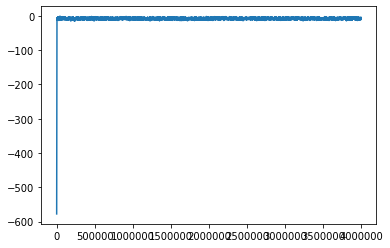

In [29]:
localEnergies = np.loadtxt("data1/localEnergies_1.txt")
plt.plot(localEnergies)

In [42]:
r = np.linspace(-5, 5, 200)

N = 11


def f(q,i):
    pos = pd.read_csv(f"data1/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(N)]

for p in processes:
    p.start()
 

density = q.get()
for i in range(N-1):
    density += q.get()

density /= N

100%|██████████| 80000000/80000000 [03:24<00:00, 390496.06it/s]


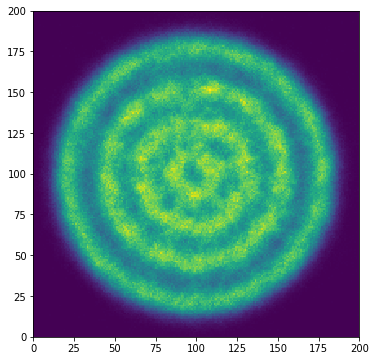

In [44]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

In [ ]:
np.random.seed(42)
N = 1000
signal = np.zeros(N)
signal[0] = np.random.normal(0,1)
for i in range(1, N):
    signal[i] = 0.5*np.random.normal(0,1) + 0.5*signal[i-1]

In [ ]:
plt.plot(signal[:1000])

In [ ]:
var = np.std(signal)**2
print(var)
print(np.sqrt(var/N))

In [ ]:
mean = np.mean(signal)
print(mean)

In [ ]:
corr = 0
for i in range(1000):
    for j in range(i,1000):
        corr += (signal[i] - mean)*(signal[j] - mean)
corr /= 1000

print(corr)

In [ ]:
corr = np.correlate(signal, signal, mode="full")

In [ ]:
plt.plot(corr[999:])

In [ ]:
conf = {}
conf["numPart"] = 10
conf["numDim"] = 3
conf["numSteps"] = 2**20
conf["stepLength"] = 0.1
conf["alpha"] = 0.4

src.runner(conf)
localEnergies = np.loadtxt("localEnergies.txt")

In [ ]:
x = np.copy(localEnergies)
ting = [np.std(x)/np.sqrt(len(x))]
for i in range(16):
    x = src.blocking(x)
    ting.append(np.std(x)/np.sqrt(len(x)))

In [ ]:
plt.plot(ting)

In [ ]:
conf = {}
conf["numPart"] = 10
conf["numDim"] = 1
conf["numSteps"] = 1000
conf["stepLength"] = 0.1
conf["alpha"] = 0.4

mu = 0.001

for i in range(100):
    src.runner(conf)
    gradAlpha = np.loadtxt("metadata.txt")
    print(conf["alpha"])
    conf["alpha"] -= mu*gradAlpha
    